In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp
tf.__version__

SEED = 42

ZDIM = 128  # latent space dim, VAE is the same as in original VAE paper https://arxiv.org/abs/1312.6114
MDIM = 1024  # MIL dim from https://arxiv.org/abs/1609.07257
BETA = 100  # from https://openreview.net/forum?id=Sy2fzU9gl

FL_FACTOR = 1  # weight of the focal loss
HL_FACTOR = 1000  # weight of the huber loss

/home/vojta/tf/lib/python3.6/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [2]:
print("Reading baskets")
u500 = pd.read_csv("train500k.csv")
print("Reading items")
items = pd.read_csv("items.csv")
print("Training tokenizer")
toki = tf.keras.preprocessing.text.Tokenizer()
toki.fit_on_texts([str(x) for x in items.itemid.to_list()])

Reading baskets
Reading items
Training tokenizer


In [3]:
print("Creating train, dev, test splits.")
train_len=int(len(u500)*0.8)
dev_len =int(len(u500)*0.1)
test_len=int(len(u500)*0.1)
corr = len(u500)-(train_len+dev_len+test_len)
train_len+=corr
train_df, dev_df, test_df = u500.iloc[:train_len],u500.iloc[train_len:train_len+dev_len],u500.iloc[train_len+dev_len:]
len(train_df), len(dev_df), len(test_df)


Creating train, dev, test splits.


(7063708, 882963, 882963)

In [4]:
class RaggedBasketGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size, toki):
        self.toki = toki
        self.batch_size=batch_size
        self.df=df
        self.length = len(self.df)
        
    def __getitem__(self, index):
        data_slice = self.df.iloc[self.batch_size*index:self.batch_size*index+self.batch_size]        
        x_train = tf.ragged.constant(toki.texts_to_sequences(data_slice.itemids)).to_tensor()        
        return x_train,x_train        
        
    def __iter__(self):
        return self

    def __len__(self):
        return int(np.floor(self.length / self.batch_size))

    def __call__(self):
        """Allows to use the size of batch when calling the training."""
        for i in range(len(self)):
            yield self[i]    

    def on_epoch_end(self):
        self.df=self.df.sample(frac=1)
    
print("Creating generators.")
    
train_gen = RaggedBasketGenerator(train_df, 512, toki)
dev_gen = RaggedBasketGenerator(dev_df, 512, toki)
test_gen = RaggedBasketGenerator(test_df, 512, toki)


Creating generators.


In [5]:
SIZE = toki.get_config()['document_count']+1

In [6]:
EPSILON = 1e-30


@tf.function
def tf_precision(true_labels, pred_labels):

    a = tf.stack([tf.math.round(pred_labels), true_labels], axis=1)
    good = tf.math.reduce_sum(
        tf.math.reduce_min(a, axis=1),
        axis=1
    )
    bad = tf.math.reduce_sum(tf.math.abs(a[:, 0, :]-a[:, 1, :]), axis=1)

    trues = tf.math.reduce_sum(true_labels, axis=1)
    predicted = tf.math.reduce_sum(tf.math.round(pred_labels), axis=1)

    ugly = good/(predicted+EPSILON)
    return tf.math.reduce_mean(ugly)


@tf.function
def tf_recall(true_labels, pred_labels):

    a = tf.stack([tf.math.round(pred_labels), true_labels], axis=1)
    good = tf.math.reduce_sum(
        tf.math.reduce_min(a, axis=1),
        axis=1
    )
    bad = tf.math.reduce_sum(tf.math.abs(a[:, 0, :]-a[:, 1, :]), axis=1)

    trues = tf.math.reduce_sum(true_labels, axis=1)
    predicted = tf.math.reduce_sum(tf.math.round(pred_labels), axis=1)

    ugly = good/(trues+EPSILON)
    return tf.math.reduce_mean(ugly)


@tf.function
def tf_f1_score(true_labels, pred_labels):

    a = tf.stack([tf.math.round(pred_labels), true_labels], axis=1)
    good = tf.math.reduce_sum(
        tf.math.reduce_min(a, axis=1),
        axis=1
    )
    bad = tf.math.reduce_sum(tf.math.abs(a[:, 0, :]-a[:, 1, :]), axis=1)

    trues = tf.math.reduce_sum(true_labels, axis=1)
    predicted = tf.math.reduce_sum(tf.math.round(pred_labels), axis=1)

    recall = good/(trues+EPSILON)
    precision = good/(predicted+EPSILON)

    f1 = 2*(precision*recall)/(precision+recall+EPSILON)
    return tf.math.reduce_mean(f1)


@tf.function
def tf_jaccard(true_labels, pred_labels):

    a = tf.stack([tf.math.round(pred_labels), true_labels], axis=1)
    good = tf.math.reduce_sum(
        tf.math.reduce_min(a, axis=1),
        axis=1
    )
    bad = tf.math.reduce_sum(tf.math.abs(a[:, 0, :]-a[:, 1, :]), axis=1)
    ugly = good/(good+bad+EPSILON)

    return tf.math.reduce_mean(ugly)


@tf.function
def cosine_loss(x, y, sample_weight=None):
    x = tf.cast(x, tf.float32)
    return tf.math.reduce_mean(tf.keras.losses.cosine_similarity(x, y))+tf.constant(1.0)+(0.1*tf.keras.losses.MSE(x, y))


scc = tf.keras.losses.CategoricalCrossentropy(
    reduction=tf.losses.Reduction.SUM_OVER_BATCH_SIZE)
sfl = tfa.losses.SigmoidFocalCrossEntropy(reduction=tf.losses.Reduction.SUM)
hbl = tf.keras.losses.Huber(reduction=tf.losses.Reduction.SUM)


def sparse_sfl(y_true, y_pred, sample_weight=None):
    sfl_loss = sfl(tf.cast(y_true, tf.float32), y_pred)
    return sfl_loss


def sparse_sfl2(y_true, y_pred, sample_weight=None):
    sfl_loss = sfl(tf.cast(y_true, tf.float32), y_pred, sample_weight)
    return sfl_loss


def ssd_hbl_loss(y_true, y_pred, sample_weight=None):
    reg_loss = hbl(y_true, y_pred, sample_weight)
    return reg_loss

In [7]:
class MILEncoding(tf.keras.Model):
    def __init__(self, size_of_latent_space):
        super().__init__()
        self.i2 = \
            tf.keras.layers.Dense(
                size_of_latent_space,
                activation='relu',
                name="Input_Layer_Mean"
            )
        self.i3 = \
            tf.keras.layers.Dense(
                size_of_latent_space,
                activation='relu',
                name="Input_Layer_Max"
            )

    def call(self, x):
        """
        Transforms input tensor of shape (samples, baskets, items embs) into (samples, baskets embs)

        1. item embeddings are transformed into space where pooling operations works (one space for each pool)
        2. pooling operations are computed
        3. results of pooling operations are concated into single vector
        """

        x = tf.cast(x, tf.float32)
        a = tf.math.count_nonzero(x, axis=2)
        b = tf.math.reduce_any(tf.math.not_equal(x, 0.), axis=2)
        r2 = tf.ragged.boolean_mask(self.i2(x), b)
        r3 = tf.ragged.boolean_mask(self.i3(x), b)

        # pooling - count
        count_items = tf.keras.backend.sum(a, axis=1)
        count_items = tf.cast(count_items, 'float32')
        count_items = tf.expand_dims(count_items, axis=1)
        # pooling - others
        # mean of emty set is nan
        mean = tf.math.reduce_sum(r2, axis=1)/(count_items+0.00001)
        # max of emty set is -inf
        maxi = tf.nn.relu(tf.math.reduce_max(r3, axis=1))
        sumi = tf.math.reduce_sum(r3, axis=1)
        # concat
        c = tf.concat([count_items, mean, maxi], axis=-1)
        return c


class MultiHotEncoder(tf.keras.Model):
    def __init__(self, size):
        super().__init__()
        self.embedding_layer = tf.keras.layers.Embedding(size, size)
        # init the layer by calling it
        self.embedding_layer(tf.ragged.constant([[2]]))
        # to produce one-hot embeddings we need
        self.embedding_layer.set_weights(
            [tf.linalg.diag(tf.concat([tf.zeros([1]), np.ones([size-1])], axis=0))])
        self.embedding_layer.trainable = False

    def call(self, x):
        return self.embedding_layer(x)  # .to_tensor()


class BasketVAE(tf.keras.Model):
    def __init__(self):
        super().__init__()

        self._seed = SEED
        self._z_dim = ZDIM
        self._m_dim = MDIM
        self._hidden = MDIM
        self._size = SIZE
        self._beta = BETA

        self._z_prior = tfp.distributions.Normal(
            tf.zeros(self._z_dim), tf.ones(self._z_dim))

        # integer to multi-hot encoding
        multi_hot_inputs = tf.keras.layers.Input(shape=[None, ], ragged=True)
        multi_hots = MultiHotEncoder(self._size)(multi_hot_inputs)

        self.multi_hot = tf.keras.Model(
            inputs=multi_hot_inputs,
            outputs=multi_hots,
            name='multi_hot'
        )

        # ENCODER
        enc_inputs = tf.keras.layers.Input(
            shape=[None, self._size], ragged=False)

        # multihots to single vector
        single_vec = MILEncoding(self._m_dim)(enc_inputs)

        # VAE encoder outputs
        z_mean = tf.keras.layers.Dense(self._z_dim)(single_vec)
        z_log_var = tf.keras.layers.Dense(self._z_dim)(single_vec)

        self.encoder = tf.keras.Model(
            inputs=enc_inputs,
            outputs=[z_mean, z_log_var],
            name='encoder'
        )

        # DECODER
        dec_inputs = tf.keras.layers.Input(shape=[self._z_dim])

        e1 = tf.keras.layers.LayerNormalization()(tf.keras.activations.swish(
            tf.keras.layers.Dense(self._hidden)(dec_inputs)))
        e2 = tf.keras.layers.LayerNormalization()(
            tf.keras.activations.swish(tf.keras.layers.Dense(self._hidden)(e1) + e1))
        e3 = tf.keras.layers.LayerNormalization()(tf.keras.activations.swish(
            tf.keras.layers.Dense(self._hidden)(e2) + e1 + e2))

        encoder_class = tf.keras.layers.Dense(
            self._size, name="class_head", activation="sigmoid")(e3)
        encoder_regress = tf.math.round(encoder_class)*tf.keras.layers.Dense(
            self._size, name="regress_head", activation="linear")(e3)
        multihot_output = tf.maximum(tf.math.round(
            encoder_class)*tf.math.maximum(encoder_regress, 1.), 0.)

        self.decoder = tf.keras.Model(
            inputs=dec_inputs,
            outputs={"classification_head": encoder_class,
                     "regress_head": encoder_regress, "multihot_output": multihot_output},
            name='decoder'
        )

    def call(self, x):
        x = self.multi_hot(x)
        z_mean, z_log_variance = self.encoder(x, training=True)
        decoded_basket = self.decoder(z_mean)
        return decoded_basket["multihot_output"]

    def encode(self, x):
        x = self.multi_hot(x)
        z_mean, z_log_variance = self.encoder(x, training=True)
        return z_mean

    def decode(self, x):
        decoded_basket = self.decoder(x)
        return decoded_basket["multihot_output"]

    def train_step(self, data):

        with tf.GradientTape() as tape:
            x, y = data

            # ground truth labels
            y = self.multi_hot(y)
            y = tf.math.reduce_sum(y, axis=1)
            y_ones = tf.keras.activations.relu(y, max_value=1.)
            gold_true = {"is_items": y_ones, "nr_of_items": y}

            # predicted values
            x = self.multi_hot(x)
            z_mean, z_log_variance = self.encoder(x, training=True)
            z_dist = tfp.distributions.Normal(
                z_mean, tf.math.exp(z_log_variance / 2))
            z = z_dist.sample(seed=self._seed)
            decoded_basket = self.decoder(z, training=True)
            predicted = {
                "is_items": decoded_basket["classification_head"], "nr_of_items": decoded_basket["regress_head"]}

            # losses
            reconstruction_loss = self.compiled_loss(
                gold_true, predicted)*self._size
            latent_loss = tf.math.reduce_mean(tfp.distributions.kl_divergence(
                z_dist, self._z_prior))*self._z_dim*self._beta
            loss = reconstruction_loss + latent_loss

        # apply gradients
        self.optimizer.minimize(
            loss, self.encoder.trainable_variables+self.decoder.trainable_variables, tape=tape)

        # metrics
        tf_jac = tf_jaccard(
            decoded_basket["multihot_output"], tf.math.reduce_sum(x, axis=1))
        tf_pr = tf_precision(
            decoded_basket["multihot_output"], tf.math.reduce_sum(x, axis=1))
        tf_rec = tf_recall(
            decoded_basket["multihot_output"], tf.math.reduce_sum(x, axis=1))
        tf_f1 = tf_f1_score(
            decoded_basket["multihot_output"], tf.math.reduce_sum(x, axis=1))

        tf_jac1 = tf_jaccard(tf.math.round(
            decoded_basket["classification_head"]), tf.math.reduce_sum(x, axis=1))
        tf_pr1 = tf_precision(tf.math.round(
            decoded_basket["classification_head"]), tf.math.reduce_sum(x, axis=1))
        tf_rec1 = tf_recall(tf.math.round(
            decoded_basket["classification_head"]), tf.math.reduce_sum(x, axis=1))
        tf_f11 = tf_f1_score(tf.math.round(
            decoded_basket["classification_head"]), tf.math.reduce_sum(x, axis=1))

        return {
            "reconstruction_loss": reconstruction_loss,
            "latent_loss": latent_loss,
            "loss": loss,
            "tf_jaccard": tf_jac,
            "tf_precision": tf_pr,
            "tf_recall": tf_rec,
            "tf_f1_score": tf_f1,
            "tf_jaccard_1": tf_jac1,
            "tf_precision_1": tf_pr1,
            "tf_recall_1": tf_rec1,
            "tf_f1_score_1": tf_f11,

        }

    def test_step(self, data):

        x, y = data

        # ground truth labels
        y = self.multi_hot(y)
        y = tf.math.reduce_sum(y, axis=1)
        y_ones = tf.keras.activations.relu(y, max_value=1.)
        gold_true = {"is_items": y_ones, "nr_of_items": y}

        # predicted values
        x = self.multi_hot(x)
        z_mean, z_log_variance = self.encoder(x, training=False)
        z_dist = tfp.distributions.Normal(
            z_mean, tf.math.exp(z_log_variance / 2))
        z = z_dist.sample(seed=self._seed)
        decoded_basket = self.decoder(z_mean, training=False)
        predicted = {
            "is_items": decoded_basket["classification_head"], "nr_of_items": decoded_basket["regress_head"]}

        # losses
        reconstruction_loss = self.compiled_loss(
            gold_true, predicted)*self._size
        latent_loss = tf.math.reduce_mean(tfp.distributions.kl_divergence(
            z_dist, self._z_prior))*self._z_dim*self._beta
        loss = reconstruction_loss + latent_loss

        # metrics
        tf_jac = tf_jaccard(
            decoded_basket["multihot_output"], tf.math.reduce_sum(x, axis=1))
        tf_pr = tf_precision(
            decoded_basket["multihot_output"], tf.math.reduce_sum(x, axis=1))
        tf_rec = tf_recall(
            decoded_basket["multihot_output"], tf.math.reduce_sum(x, axis=1))
        tf_f1 = tf_f1_score(
            decoded_basket["multihot_output"], tf.math.reduce_sum(x, axis=1))

        tf_jac1 = tf_jaccard(tf.math.round(
            decoded_basket["classification_head"]), tf.math.reduce_sum(x, axis=1))
        tf_pr1 = tf_precision(tf.math.round(
            decoded_basket["classification_head"]), tf.math.reduce_sum(x, axis=1))
        tf_rec1 = tf_recall(tf.math.round(
            decoded_basket["classification_head"]), tf.math.reduce_sum(x, axis=1))
        tf_f11 = tf_f1_score(tf.math.round(
            decoded_basket["classification_head"]), tf.math.reduce_sum(x, axis=1))

        return {
            "reconstruction_loss": reconstruction_loss,
            "latent_loss": latent_loss,
            "loss": loss,
            "tf_jaccard": tf_jac,
            "tf_precision": tf_pr,
            "tf_recall": tf_rec,
            "tf_f1_score": tf_f1,
            "tf_jaccard_1": tf_jac1,
            "tf_precision_1": tf_pr1,
            "tf_recall_1": tf_rec1,
            "tf_f1_score_1": tf_f11,
        }

In [16]:
lr = 0.001
EPOCHS = 10
STEPS_PER_EPOCH = len(train_gen)

lr = tf.keras.optimizers.schedules.CosineDecay(lr, STEPS_PER_EPOCH*EPOCHS)

m = BasketVAE()

m.compile(
    optimizer=tf.keras.optimizers.Adam(lr,),
    loss={"is_items": FL_FACTOR*sparse_sfl, "nr_of_items": lambda x,
          y: HL_FACTOR*ssd_hbl_loss(x, y)}
)
history = m.fit(train_gen, validation_data=dev_gen, epochs=10)

Epoch 1/10
13796/13796 [==============================] - 252s 18ms/step - reconstruction_loss: 582353.5813 - latent_loss: 23717.9546 - loss: 137594.6094 - tf_jaccard: 0.8060 - tf_precision: 0.8651 - tf_recall: 0.8578 - tf_f1_score: 0.8557 - tf_jaccard_1: 0.8184 - tf_precision_1: 0.8194 - tf_recall_1: 0.9244 - tf_f1_score_1: 0.8572 - val_reconstruction_loss: 144718.9375 - val_latent_loss: 21183.7578 - val_loss: 165902.6875 - val_tf_jaccard: 0.8991 - val_tf_precision: 0.9731 - val_tf_recall: 0.9218 - val_tf_f1_score: 0.9450 - val_tf_jaccard_1: 0.9147 - val_tf_precision_1: 0.9155 - val_tf_recall_1: 0.9987 - val_tf_f1_score_1: 0.9484
Epoch 2/10
13796/13796 [==============================] - 252s 18ms/step - reconstruction_loss: 113758.9422 - latent_loss: 20558.3330 - loss: 98069.3438 - tf_jaccard: 0.9323 - tf_precision: 0.9756 - tf_recall: 0.9534 - tf_f1_score: 0.9633 - tf_jaccard_1: 0.9110 - tf_precision_1: 0.9117 - tf_recall_1: 0.9985 - tf_f1_score_1: 0.9442 - val_reconstruction_loss: 9

In [17]:
m.summary()

Model: "basket_vae_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
multi_hot (Functional)       (None, None, 1427)        2036329   
_________________________________________________________________
encoder (Functional)         [(None, 128), (None, 128) 3449344   
_________________________________________________________________
decoder (Functional)         {'classification_head': ( 5162790   
Total params: 10,648,463
Trainable params: 8,612,134
Non-trainable params: 2,036,329
_________________________________________________________________


<AxesSubplot:>

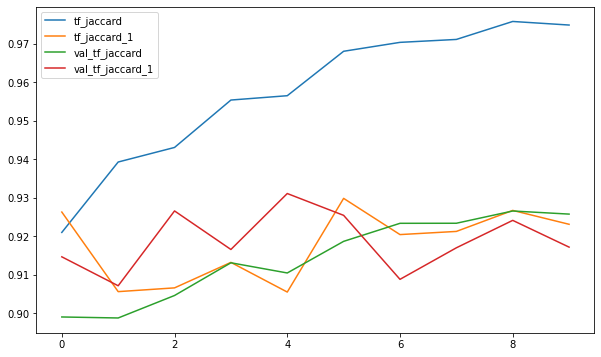

In [18]:
pd.DataFrame(history.history)[['tf_jaccard', 'tf_jaccard_1',
                               'val_tf_jaccard', 'val_tf_jaccard_1']].plot(figsize=(10, 6))

In [19]:
evaluated = m.evaluate(test_gen)

1724/1724 [==============================] - 18s 10ms/step - reconstruction_loss: 36801.4866 - latent_loss: 15380.2485 - loss: 49824.1719 - tf_jaccard: 0.9257 - tf_precision: 0.9958 - tf_recall: 0.9293 - tf_f1_score: 0.9608 - tf_jaccard_1: 0.9241 - tf_precision_1: 0.9244 - tf_recall_1: 0.9993 - tf_f1_score_1: 0.9524


In [20]:
pizzas     = [20915, 32989, 31987, 14303, 45719, 57401, 21647, 21028, 33460]
vegetables = [33353, 27542, 18836, 49474, 11590, 12996, 16070, 36216, 23433]
ice_creams = [57993, 48535, 11326, 45922, 17487, 16561, 13154, 53378, 50303]
vines      = [20075, 35593, 31155, 12360, 26742, 41211, 37539, 51601, 32872]

In [21]:
import random
from random import shuffle
from sklearn.manifold import TSNE

random.seed(42)

items_to_plot = []
colors_to_plot = []

group_size=500

#pizzas
for i in range(group_size):
    shuffle(pizzas)
    items_to_plot.append(" ".join([str(x) for x in pizzas[:4]]))
    colors_to_plot.append('blue')

# pizzas / vegetables
for i in range(group_size):
    shuffle(pizzas)
    shuffle(vegetables)
    items_to_plot.append(" ".join([str(x) for x in pizzas[:2]]+[str(x) for x in vegetables[:2]]))
    colors_to_plot.append('MediumSeaGreen')     
    
#vegetables
for i in range(group_size):
    shuffle(vegetables)
    items_to_plot.append(" ".join([str(x) for x in vegetables[:4]]))
    colors_to_plot.append('green')

# ice_creams / vegetables
for i in range(group_size):
    shuffle(ice_creams)
    shuffle(vegetables)
    items_to_plot.append(" ".join([str(x) for x in ice_creams[:2]]+[str(x) for x in vegetables[:2]]))
    colors_to_plot.append('GreenYellow')    
    
#ice_creams
for i in range(group_size):
    shuffle(ice_creams)
    items_to_plot.append(" ".join([str(x) for x in ice_creams[:4]]))
    colors_to_plot.append('orange')


# ice_creams / vines
for i in range(group_size):
    shuffle(ice_creams)
    shuffle(vines)
    items_to_plot.append(" ".join([str(x) for x in ice_creams[:2]]+[str(x) for x in vines[:2]]))
    colors_to_plot.append('HotPink')
    
#vines
for i in range(group_size):
    shuffle(vines)
    items_to_plot.append(" ".join([str(x) for x in vines[:4]]))
    colors_to_plot.append('red')

    
# pizzas / vines
for i in range(group_size):
    shuffle(pizzas)
    shuffle(vines)
    items_to_plot.append(" ".join([str(x) for x in pizzas[:2]]+[str(x) for x in vines[:2]]))
    colors_to_plot.append('purple')
    
    
# one from all    
for i in range(group_size):
    shuffle(ice_creams)
    shuffle(vines)
    shuffle(pizzas)
    shuffle(vegetables)
    items_to_plot.append(" ".join([str(x) for x in ice_creams[:1]]+[str(x) for x in vines[:1]]+[str(x) for x in pizzas[:1]]+[str(x) for x in vegetables[:1]]))
    colors_to_plot.append('black')

def encode(model, ll):
    x_train = tf.ragged.constant(toki.texts_to_sequences(ll)).to_tensor()    
    z_mean = model.encode(x_train) 
    return z_mean

# get embeddings for items
bas_items_embs = encode(m, items_to_plot)

# calculate t-sne 
tsne_coordinates3 = TSNE(n_components=2, metric="cosine", angle=0.9, perplexity=1000, random_state=1).fit(bas_items_embs)
tsne_coordinates3 = tsne_coordinates3.embedding_


/home/vojta/tf/lib/python3.6/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


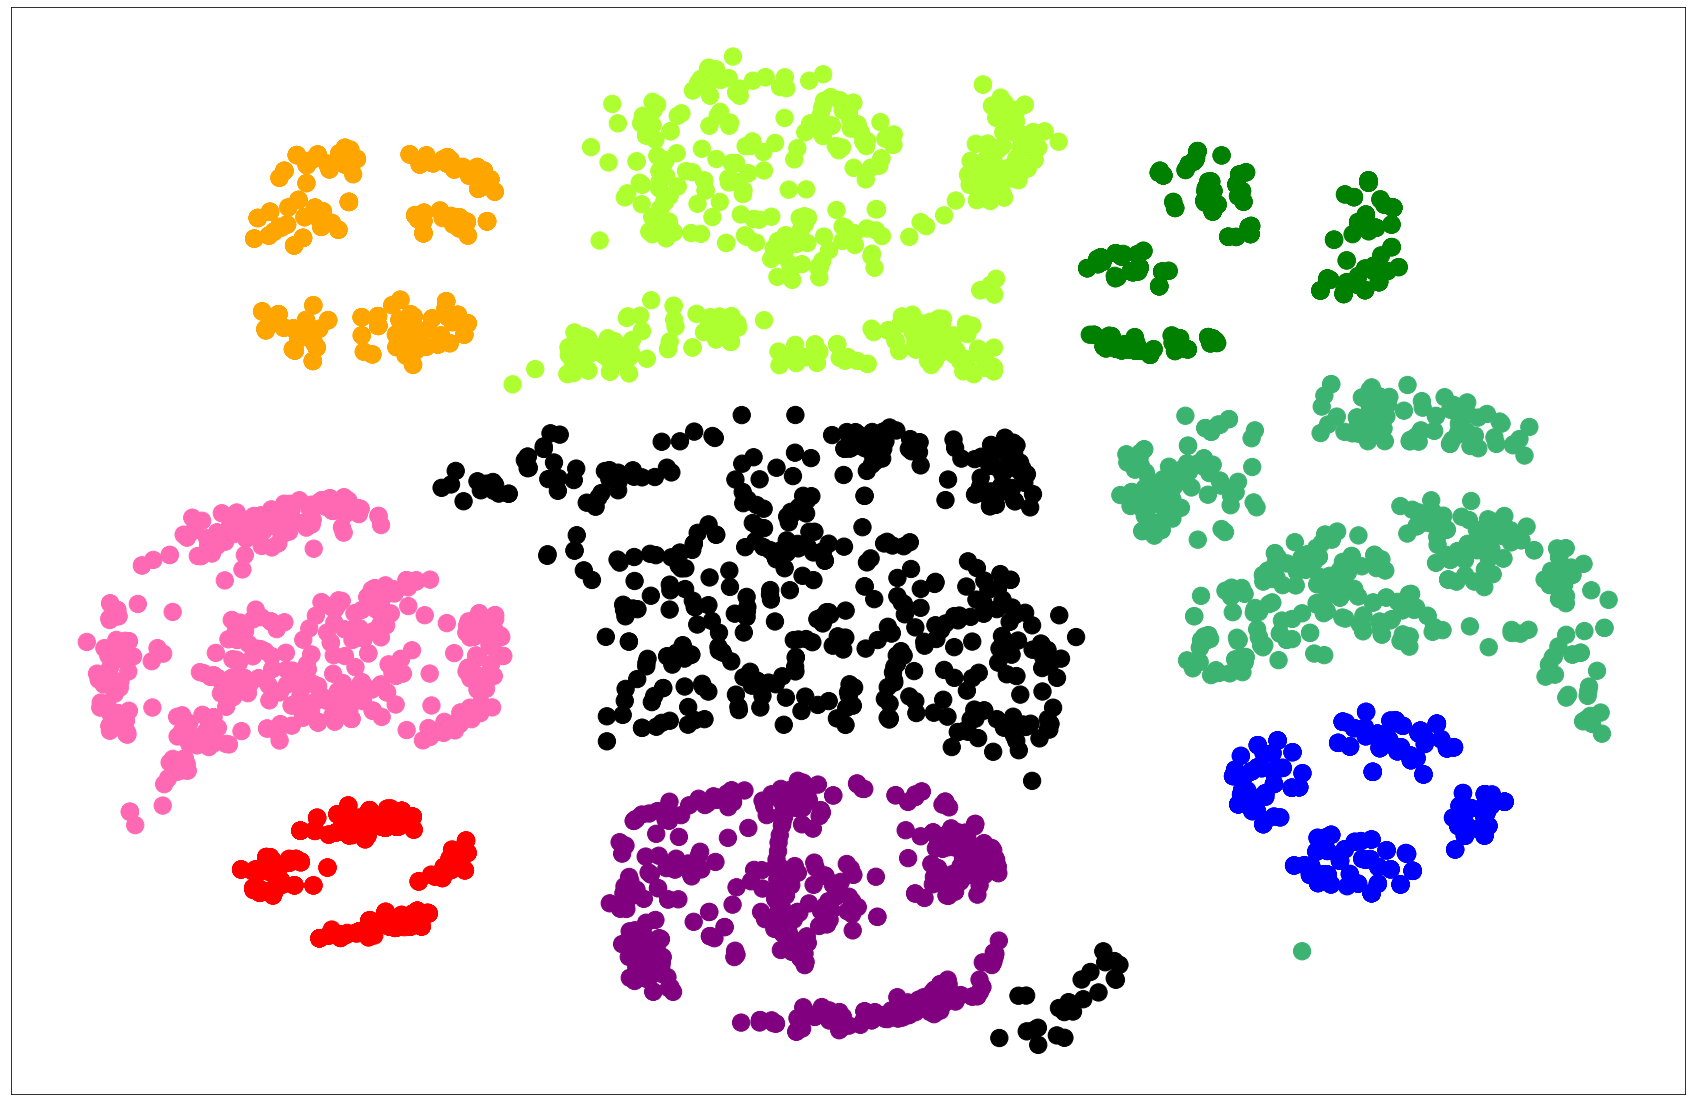

In [25]:
import matplotlib.pyplot as plt 
angle=320

theta = np.deg2rad(angle);

cs = np.cos(theta);
sn = np.sin(theta);

xs=[]
ys=[]
for i in range(len(bas_items_embs)):
    x0, y0 = (tsne_coordinates3[i,0], tsne_coordinates3[i,1])
    px = x0 * cs - y0 * sn; 
    py = x0 * sn + y0 * cs;
    xs.append(px)
    ys.append(py)

fig, ax = plt.subplots(figsize=(30,20))
#plt.scatter(x = tsne_coordinates3[:,0], y=tsne_coordinates3[:,1], s=5, c=colors_to_plot)
ax.scatter(x = xs, y=ys, s=300, c=colors_to_plot)
plt.title("")
plt.xticks([])
plt.yticks([])
fig.show()

In [26]:
from PIL import Image
from skimage.transform import resize
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


def read_img(p):
    try: 
        return Image.open(p)
    except:
        print(p)
        return Image.fromarray(np.zeros((183, 256, 3)).astype(np.uint8), 'RGB')

def make_image_basket(s):
    
    l=s.split(" ")
    shuffle(l)

    img1 = read_img("images/"+l[0]+".jpg")
    img2 = read_img("images/"+l[1]+".jpg")
    img3 = read_img("images/"+l[2]+".jpg")
    img4 = read_img("images/"+l[3]+".jpg")

    np_img1 = np.asarray(img1)
    np_img2 = np.asarray(img2)
    np_img3 = np.asarray(img3)
    np_img4 = np.asarray(img4)


    np_img=np.vstack([np.hstack([img1,img2]),np.hstack([img3,img4])])
    np_img = resize(np_img,(np_img.shape[0]//5,np_img.shape[1]//5))
    np_img[0:1,:]=0
    np_img[:,0:1]=0
    np_img[-1:,:]=0
    np_img[:,-1:]=0
    img=Image.fromarray((np_img*255).astype(np.uint8), 'RGB')
    return (np_img*255).astype(np.uint8)
    return img

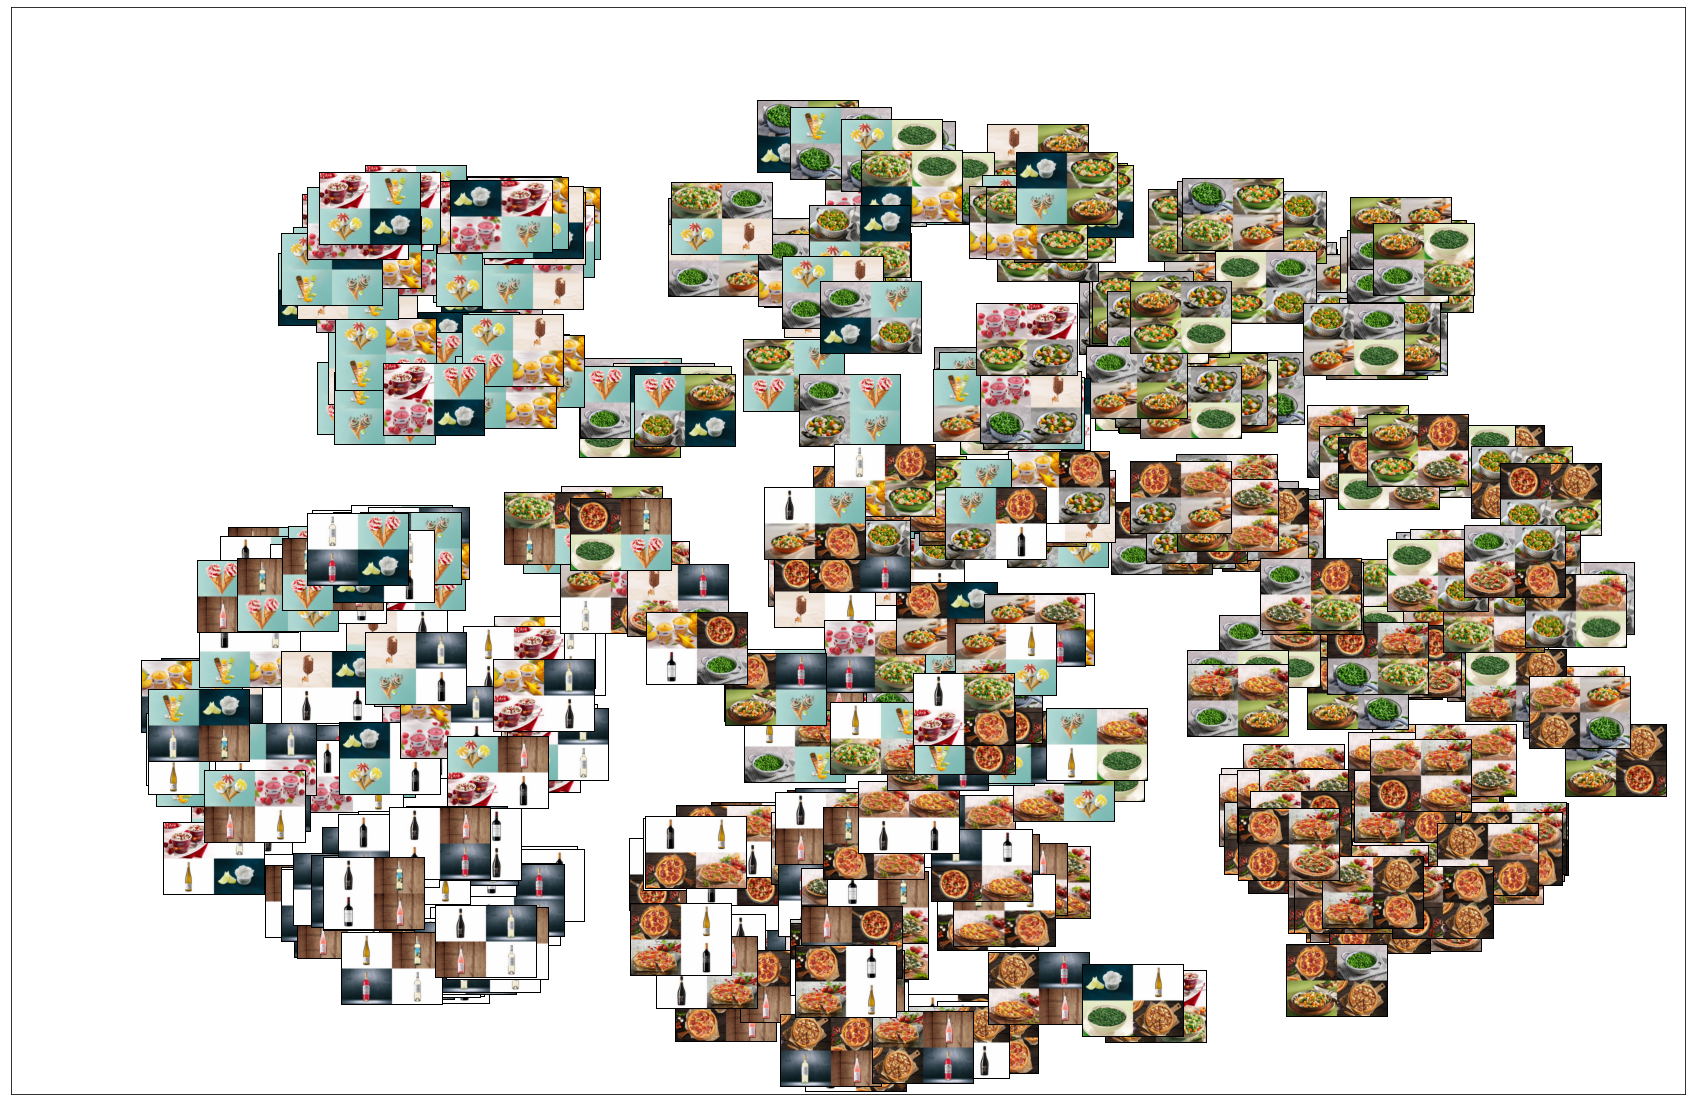

In [27]:
angle=320

theta = np.deg2rad(angle);

cs = np.cos(theta);
sn = np.sin(theta);


fig, ax = plt.subplots(figsize=(30,20))
ax.scatter(x = tsne_coordinates3[:,0], y=tsne_coordinates3[:,1], s=5, c="white")


for i in range(0,len(bas_items_embs),10):
    x0, y0, basket = (tsne_coordinates3[i,0], tsne_coordinates3[i,1], items_to_plot[i])
    
    px = x0 * cs - y0 * sn; 
    py = x0 * sn + y0 * cs;
    
    ab = AnnotationBbox(OffsetImage(make_image_basket(basket)), (px, py), frameon=False)
    ax.add_artist(ab)

plt.title("")
plt.xticks([])
plt.yticks([])
fig.show()